In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks

In [29]:
using Plots

In [3]:
import Random: Xoshiro, AbstractRNG

In [4]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [5]:
function generate_addresses(n_samples::Int,  n_vsa::Int, rng::AbstractRNG)
    header = random_symbols((n_vsa, 1), rng)
    powers = collect(0:n_samples-1)
    addresses = [v_bind(header, header .* p)[:,1] for p in powers]
    addresses = stack(addresses, dims=2)
    return header, addresses
end

generate_addresses (generic function with 1 method)

In [45]:
function generate_copy_dataset(rng::AbstractRNG; num_samples::Int=1000, max_length::Int=50, vocab_size::Int=100)
    dataset = []
    for _ in 1:num_samples
        length = rand(rng, 5:max_length)
        sequence = [rand(1:vocab_size) for _ in 1:length]
        #pad with zeros
        sequence = cat(sequence, zeros(Int, max_length - length), dims=1)
        push!(dataset, (sequence, sequence))  # Input and target identical
    end
    return dataset
end

generate_copy_dataset (generic function with 1 method)

In [46]:
copy_data = generate_copy_dataset(rng);

In [52]:
function generate_codebook(rng::AbstractRNG; vocab_size::Int=100, n_hd::Int=512)
    symbols = random_symbols((n_hd, vocab_size), rng)
    codebook = Dict{Int, Vector{<:Real}}()
    for i in 1:vocab_size
        codebook[i] = symbols[:,i]
    end
    codebook[Int(0)] = zeros(n_hd)
    return codebook
end

generate_codebook (generic function with 1 method)

In [53]:
cb = generate_codebook(rng)

Dict{Int64, Vector{<:Real}} with 101 entries:
  5  => [0.529563, -0.995947, 0.0689582, 0.54229, 0.297394, 0.158265, -0.483717…
  56 => [0.176834, 0.0763475, -0.356587, -0.844895, -0.92044, 0.197344, 0.33157…
  35 => [0.0245876, -0.500913, -0.155849, -0.581486, 0.561486, -0.764651, 0.003…
  55 => [-0.439887, 0.152696, -0.534774, 0.0552417, 0.935253, 0.316189, 0.48995…
  60 => [-0.00162315, -0.417731, 0.431721, 0.568266, 0.152231, -0.0988328, -0.6…
  30 => [-0.654007, 0.540724, -0.245784, 0.389605, 0.855263, 0.515303, -0.84809…
  32 => [0.113388, 0.474913, -0.371993, 0.147997, 0.658766, -0.0904858, 0.67890…
  6  => [-0.27219, -0.794492, 0.399784, -0.507107, -0.758863, -0.598383, -0.575…
  67 => [-0.420354, 0.742267, 0.170344, -0.234581, -0.857722, 0.636233, 0.13722…
  45 => [-0.681128, 0.918862, -0.894539, 0.248011, -0.571108, -0.623147, 0.5317…
  73 => [-0.38563, 0.600608, 0.25176, -0.400246, -0.378111, -0.784769, 0.716997…
  64 => [0.138504, 0.22436, 0.753341, 0.0308291, 0.988878, 0.50

In [ ]:
typeof(copy_data[1][1])

In [ ]:
function map_symbols(dataset::Vector{<:Any}, codebook::Dict{<:Int, <:Vector{<:Real}})
    map_fn = x -> stack([codebook[k] for k in x])

    output = [map_fn.(data) for data in dataset]
    return output
end

map_symbols (generic function with 1 method)

In [27]:
copy_hd = map_symbols(copy_data, cb)

1000-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([-0.1413261890411377 0.4918757677078247 … 0.9176536798477173 0.7629886865615845; -0.1674576997756958 -0.09412539005279541 … -0.3355804681777954 -0.4282902479171753; … ; -0.4145035743713379 0.17394185066223145 … 0.10816144943237305 -0.8888585567474365; -0.09904801845550537 0.23653292655944824 … -0.8135879039764404 0.34116315841674805], [-0.1413261890411377 0.4918757677078247 … 0.9176536798477173 0.7629886865615845; -0.1674576997756958 -0.09412539005279541 … -0.3355804681777954 -0.4282902479171753; … ; -0.4145035743713379 0.17394185066223145 … 0.10816144943237305 -0.8888585567474365; -0.09904801845550537 0.23653292655944824 … -0.8135879039764404 0.34116315841674805])
 ([-0.8886500597000122 0.08398866653442383 … 0.4855843782424927 -0.4295724630355835; 0.7152628898620605 -0.3133620023727417 … -0.26882898807525635 -0.5942319631576538; … ; -0.7261738777160645 -0.6127264499664307 … 0.08606255054473877 0.34972965717315674; -0.0037

In [59]:
using MLUtils: BatchView

In [62]:
train_set = BatchView(copy_hd, batchsize= 32)

BatchView([([-0.1413261890411377 0.4918757677078247 … 0.9176536798477173 0.7629886865615845; -0.1674576997756958 -0.09412539005279541 … -0.3355804681777954 -0.4282902479171753; … ; -0.4145035743713379 0.17394185066223145 … 0.10816144943237305 -0.8888585567474365; -0.09904801845550537 0.23653292655944824 … -0.8135879039764404 0.34116315841674805], [-0.1413261890411377 0.4918757677078247 … 0.9176536798477173 0.7629886865615845; -0.1674576997756958 -0.09412539005279541 … -0.3355804681777954 -0.4282902479171753; … ; -0.4145035743713379 0.17394185066223145 … 0.10816144943237305 -0.8888585567474365; -0.09904801845550537 0.23653292655944824 … -0.8135879039764404 0.34116315841674805]), ([-0.8886500597000122 0.08398866653442383 … 0.4855843782424927 -0.4295724630355835; 0.7152628898620605 -0.3133620023727417 … -0.26882898807525635 -0.5942319631576538; … ; -0.7261738777160645 -0.6127264499664307 … 0.08606255054473877 0.34972965717315674; -0.003731846809387207 -0.16723108291625977 … -0.24175179004

In [56]:
train_xs = [x[1] for x in copy_hd]

1000-element Vector{Matrix{Float64}}:
 [-0.1413261890411377 0.4918757677078247 … 0.9176536798477173 0.7629886865615845; -0.1674576997756958 -0.09412539005279541 … -0.3355804681777954 -0.4282902479171753; … ; -0.4145035743713379 0.17394185066223145 … 0.10816144943237305 -0.8888585567474365; -0.09904801845550537 0.23653292655944824 … -0.8135879039764404 0.34116315841674805]
 [-0.8886500597000122 0.08398866653442383 … 0.4855843782424927 -0.4295724630355835; 0.7152628898620605 -0.3133620023727417 … -0.26882898807525635 -0.5942319631576538; … ; -0.7261738777160645 -0.6127264499664307 … 0.08606255054473877 0.34972965717315674; -0.003731846809387207 -0.16723108291625977 … -0.2417517900466919 -0.7047712802886963]
 [-0.007416248321533203 -0.40538132190704346 … 0.23107171058654785 -0.5976600646972656; -0.32841217517852783 -0.8865422010421753 … -0.584942102432251 0.9694374799728394; … ; 0.3554117679595947 -0.016058921813964844 … 0.9793449640274048 0.759468674659729; 0.41917359828948975 0.58966946

In [57]:
train_ys = [x[2] for x in copy_hd]

1000-element Vector{Matrix{Float64}}:
 [-0.1413261890411377 0.4918757677078247 … 0.9176536798477173 0.7629886865615845; -0.1674576997756958 -0.09412539005279541 … -0.3355804681777954 -0.4282902479171753; … ; -0.4145035743713379 0.17394185066223145 … 0.10816144943237305 -0.8888585567474365; -0.09904801845550537 0.23653292655944824 … -0.8135879039764404 0.34116315841674805]
 [-0.8886500597000122 0.08398866653442383 … 0.4855843782424927 -0.4295724630355835; 0.7152628898620605 -0.3133620023727417 … -0.26882898807525635 -0.5942319631576538; … ; -0.7261738777160645 -0.6127264499664307 … 0.08606255054473877 0.34972965717315674; -0.003731846809387207 -0.16723108291625977 … -0.2417517900466919 -0.7047712802886963]
 [-0.007416248321533203 -0.40538132190704346 … 0.23107171058654785 -0.5976600646972656; -0.32841217517852783 -0.8865422010421753 … -0.584942102432251 0.9694374799728394; … ; 0.3554117679595947 -0.016058921813964844 … 0.9793449640274048 0.759468674659729; 0.41917359828948975 0.58966946

In [34]:
copy_hd[1][2][:,:,1:1] |> size

(512, 33, 1)

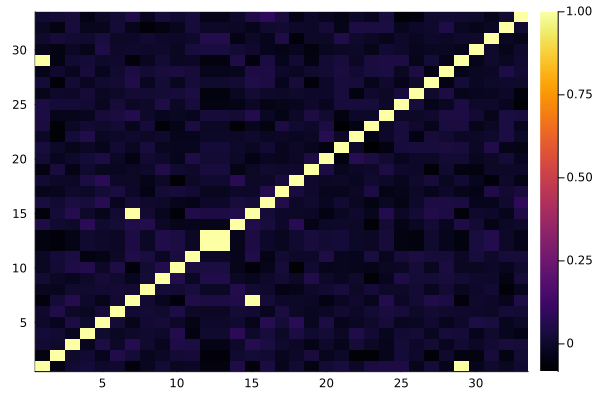

In [38]:
heatmap(similarity_outer(copy_hd[1][1][:,:,1:1], copy_hd[1][2][:,:,1:1])[:,:,1])

In [ ]:
function generate_reversal_dataset(rng::AbstractRNG; num_samples=1000, max_length=50, vocab_size=100)
    dataset = []
    for _ in 1:num_samples
        length = rand(rng, 5:max_length)
        sequence = [rand(rng, 1:vocab_size) for _ in 1:length]
        reversed_sequence = reverse(sequence)
        push!(dataset, (sequence, reversed_sequence))
    end
    return dataset
end

generate_reversal_dataset (generic function with 1 method)

In [ ]:
reversal_data = generate_reversal_dataset(rng);

In [25]:
function generate_retrieval_dataset(rng::AbstractRNG; num_samples=1000, context_length=100, vocab_size=100, special_token=999)
    dataset = []
    for _ in 1:num_samples
        haystack = [rand(rng, 1:vocab_size) for _ in 1:context_length-1]
        needle_position = rand(rng, 1:context_length-1)
        needle_value = rand(rng, 1:vocab_size)
        insert!(haystack, needle_position, needle_value)
        query = vcat(special_token, needle_position)
        target = [haystack[needle_position]]
        push!(dataset, (vcat(haystack, query), target))
    end
    return dataset
end

generate_retrieval_dataset (generic function with 1 method)

In [26]:
needle_data = generate_retrieval_dataset(rng);

In [28]:
needle_data[1]

([38, 83, 93, 54, 31, 94, 59, 43, 11, 11  …  61, 41, 82, 92, 25, 56, 27, 40, 999, 32], [22])

In [32]:
needle_data[1][1][32]

22

In [36]:
function generate_sorting_dataset(rng::AbstractRNG; num_samples=1000, max_length=20, vocab_size=100)
    dataset = []
    for _ in 1:num_samples
        length = rand(rng, 5:max_length)
        sequence = [rand(rng, 1:vocab_size) for _ in 1:length]
        sorted_sequence = sort(sequence)
        push!(dataset, (sequence, sorted_sequence))
    end
    return dataset
end

generate_sorting_dataset (generic function with 1 method)

In [38]:
sorting_data = generate_sorting_dataset(rng);

In [39]:
function generate_pattern_dataset(rng::AbstractRNG; num_samples::Int=1000, pattern_length::Int=3, vocab_size::Int=100, special_token::Int=999)
    dataset = []
    for _ in 1:num_samples
        context_length = rand(20:50)
        context = [rand(rng, 1:vocab_size) for _ in 1:context_length]
        pattern = [rand(rng, 1:vocab_size) for _ in 1:pattern_length]
        # Insert pattern at random position
        insert_pos = rand(rng, 1:context_length - pattern_length + 1)
        context[insert_pos:insert_pos+pattern_length-1] = pattern
        push!(dataset, (vcat(context, special_token, pattern[1:end-1]), [pattern[end]]))
    end
    return dataset
end

generate_pattern_dataset (generic function with 2 methods)

In [41]:
pattern_data = generate_pattern_dataset(rng);

In [42]:
pattern_data[1]

([77, 15, 31, 90, 19, 19, 97, 1, 13, 66  …  19, 91, 25, 65, 90, 92, 8, 999, 97, 1], [13])

In [9]:
function generate_depth_dataset(rng::AbstractRNG; num_samples::Int=1000, max_length::Int=50, vocab_size::Int=100)
    dataset = []
    for _ in 1:num_samples
        length = rand(5:max_length)
        sequence = [rand(0:vocab_size-1) for _ in 1:length]
        depth_values = [rand() for _ in 1:length]
        # Assign higher depth values to important tokens
        important_indices = shuffle(1:length)[1:div(length,3)]
        for idx in important_indices
            depth_values[idx] += 2.0
        end
        target = [sequence[i] for i in important_indices]
        push!(dataset, ((sequence, depth_values), target))
    end
    return dataset
end

generate_depth_dataset (generic function with 1 method)